<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №1</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили:
- _ _ _ Дмитриченко Д.А. _ _ _
- _ _ _ Опрышко М.А. _ _ _

Проверил: _ _ _ Осипенко И.В. _ _ _

<center>  Новосибирск, 2025  </center>


In [118]:
# Python 3.10
import pandas as pd
import numpy  as np
import category_encoders as ce

import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [119]:
df = pd.read_csv(
    '../Data/Moscow_Housing_Price_Dataset_nan_24.csv', # путь к файлу через символ "/", (используйте автодополнение)
    sep       = ',' ,
    decimal   = '.' ,
    header    = 0,  # если заголовки в нулевой строке таблицы,
        #  header=None если заголовки отсутствуют
    #na_values =  ['???', ' '], # доп. символы для обозначения отсутствующих значений
)

df[0:2] # отобразить первые строки таблицы df

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,>??<,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation


In [120]:
print  (df.shape)
nrow = df.shape[0]
ncol = df.shape[1]
print ("Итого: " + str(nrow) + " записи, " + str(ncol) + " столбец (признак).")

(22676, 12)
Итого: 22676 записи, 12 столбец (признак).


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             22664 non-null  object 
 1   Apartment type    22674 non-null  object 
 2   Metro station     22675 non-null  object 
 3   Minutes to metro  22676 non-null  float64
 4   Region            22676 non-null  object 
 5   Number of rooms   22675 non-null  float64
 6   Area              22676 non-null  float64
 7   Living area       22676 non-null  float64
 8   Kitchen area      22674 non-null  float64
 9   Floor             22676 non-null  float64
 10  Number of floors  22676 non-null  int64  
 11  Renovation        22675 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 2.1+ MB


In [122]:
df['Price'] = pd.to_numeric(
    df['Price'],      # Входной набор значений
    errors = 'coerce' # режим замены на NaN
)

In [123]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,22663.0,3.609019e+07,8.271023e+07,1150000.0,7066664.0,11343200.0,24753001.50,2.455020e+09
Minutes to metro,22676.0,1.188860e+01,6.204457e+00,0.0,7.0,11.0,15.00,6.000000e+01
Number of rooms,22675.0,2.043131e+00,1.523620e+00,0.0,1.0,2.0,3.00,1.200000e+01
Area,22676.0,7.196683e+01,6.836861e+01,6.0,37.4,53.3,77.14,1.117000e+03
Living area,22676.0,3.851795e+01,3.812428e+01,2.0,17.6,28.5,43.20,5.668000e+02
Kitchen area,22674.0,1.259406e+01,7.728284e+00,1.0,8.6,10.6,14.50,1.220000e+02
Floor,22676.0,9.190466e+00,7.549996e+00,1.0,4.0,8.0,13.00,9.200000e+01
Number of floors,22676.0,1.655609e+01,9.779297e+00,1.0,11.0,16.0,20.00,9.700000e+01


In [124]:
# описание для НЕ числовых значений, при их наличии
if (df.dtypes == 'object').sum() >0:
    print(df.describe(include=['object', 'bool']).T )

                count unique                top   freq
Apartment type  22674      2          Secondary  13151
Metro station   22675    547  Красногвардейская   2697
Region          22676      2             Moscow  16113
Renovation      22675      4           Cosmetic  12788


## Изменение названия признаков

In [125]:
df.columns

Index(['Price', 'Apartment type', 'Metro station', 'Minutes to metro',
       'Region', 'Number of rooms', 'Area', 'Living area', 'Kitchen area',
       'Floor', 'Number of floors', 'Renovation'],
      dtype='object')

## Пропущенные значения

In [126]:
print ( df.isna().sum() ) # используем print для компактного вывода

Price               13
Apartment type       2
Metro station        1
Minutes to metro     0
Region               0
Number of rooms      1
Area                 0
Living area          0
Kitchen area         2
Floor                0
Number of floors     0
Renovation           1
dtype: int64


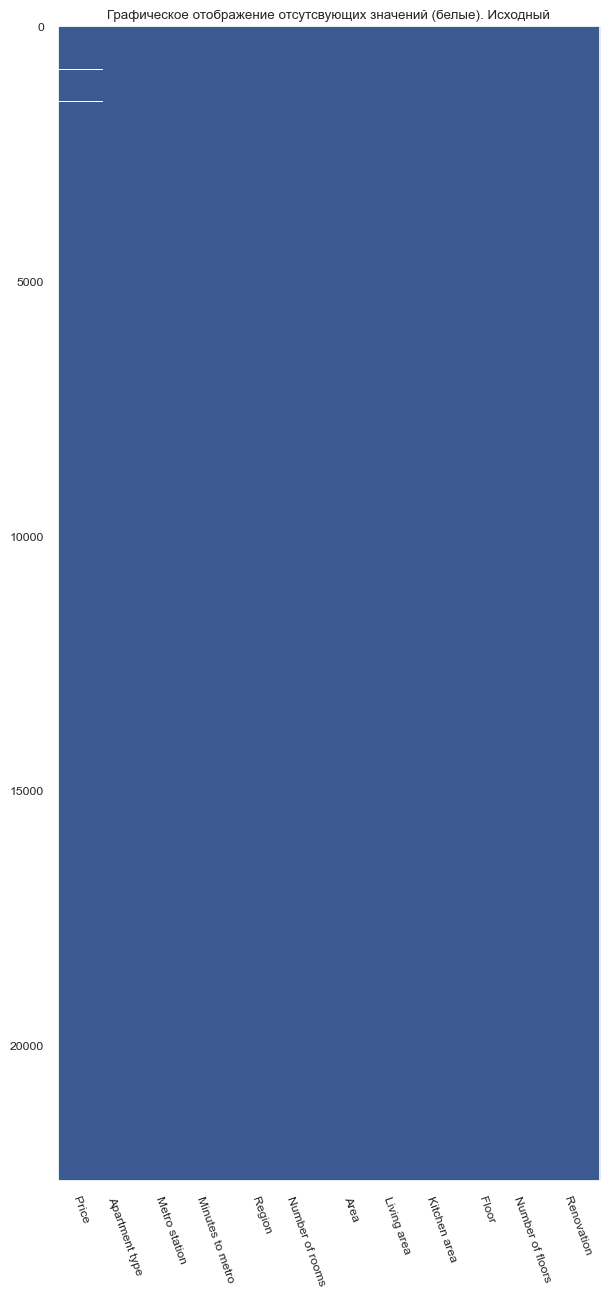

In [127]:
from matplotlib.colors import ListedColormap
def plotTableNA(dataF, addToTilte =""):
    '''  Функция для построения графика отображение отсутсвующих значений'''
    if   len(dataF.columns)> 20:   K = 3
    elif len(dataF.columns)== 1:   K = 1
    else:                          K = 1.7

    figSizeH = 15        # размер полотна, высота
    figSizeW =int(len(dataF.columns)/K) # размер полотна, ширина
    fig, ax = plt.subplots( figsize=(figSizeW, figSizeH)) # создать полотно для рисования, figsize-размер в дюймах

    # отрисовать матрицу значений функцией imshow. Применяется цветовая палитра
    plt.imshow( dataF.isna(),
                cmap = ListedColormap([ '#3B5A92', 'white', ]), # выбор цветовой шкалы, аналог cm.get_cmap('jet'),
                aspect='auto',  # ‘auto’ | ‘equal’ | scalar]    # режим соотнощения сторон
                interpolation= 'none',)                         # отключить размытие
    ax.set_xticks(np.arange(len(dataF.columns)))
    ax.set_xticklabels(dataF.columns, rotation=-70,)
    plt.title("Графическое отображение отсутсвующих значений (белые). "+ addToTilte)
    plt.grid(False) # Сетка
#-------------------------------------
# Вызов функции с указанием параметров
plotTableNA( dataF=df, addToTilte="Исходный" )

In [128]:
print("Размер исходного DataFrame", df.shape)
print("Вар.3.1. Размер при исключении по строкам",  df.dropna(axis='index', how='any').shape)
print("Вар.3.2. Размер при исключении по столбцам", df.dropna(axis='columns', how='any').shape)

Размер исходного DataFrame (22676, 12)
Вар.3.1. Размер при исключении по строкам (22656, 12)
Вар.3.2. Размер при исключении по столбцам (22676, 6)


In [129]:
df = df.dropna(axis='index', how='any')
print("Размер таблицы после исключения пропусков", df.shape)

Размер таблицы после исключения пропусков (22656, 12)


In [130]:
print ("Итого: " + str(df.shape[0]) + " записи, " + str(df.shape[1]) + " столбец (признак).")

Итого: 22656 записи, 12 столбец (признак).


### Замена значений (mapping) + One-Hot encoding

Нужно использовать mapping, потому что иначе информация была бы избыточной (ловушка фиктивных переменных)

In [131]:
df.shape

(22656, 12)

In [132]:
# описание для НЕ числовых значений, при их наличии
if (df.dtypes == 'object').sum() >0:
    print(df.describe(include=['object', 'bool']).T )

                count unique                top   freq
Apartment type  22656      2          Secondary  13134
Metro station   22656    547  Красногвардейская   2696
Region          22656      2             Moscow  16099
Renovation      22656      4           Cosmetic  12780


In [133]:
df['Apartment type'].unique() # получить массив уникальных значений в столбце

array(['Secondary', 'New building'], dtype=object)

In [134]:
# применить карту соотвествий имеющихся и новых значений. Тип данных результата - int, т.к. замена на числа
df['Apartment_type_Digit'] = df['Apartment type'].map(
    {
        'Secondary'  : 0,
        'New building' : 1,
    }
)
df[[ 'Apartment type' , 'Apartment_type_Digit']] [:2]

,Apartment type,Apartment_type_Digit
1,Secondary,0
2,Secondary,0


In [135]:
df.shape

(22656, 13)

In [136]:
df['Region'].unique() # получить массив уникальных значений в столбце

array(['Moscow region', 'Moscow'], dtype=object)

In [137]:
# применить карту соотвествий имеющихся и новых значений. Тип данных результата - int, т.к. замена на числа
df['Region_Digit'] = df['Region'].map(
    {
        'Moscow region'  : 0,
        'Moscow' : 1,
    }
)
df[[ 'Region' , 'Region_Digit']] [:2]

,Region,Region_Digit
1,Moscow region,0
2,Moscow region,0


In [138]:
df.shape

(22656, 14)

### One-Hot encoding

One-Hot Encoding (OHE) — это метод кодирования категориальных признаков в числовой вид, при котором для каждого уникального значения признака создаётся отдельный бинарный (0/1) столбец.

Модели машинного обучения (линейная регрессия, логистическая регрессия, деревья решений и др.) работают только с числами. OHE позволяет представить категории так, чтобы модель видела их как набор независимых бинарных признаков.

In [139]:
df['Renovation'].unique() # получить массив уникальных значений в столбце

array(['European-style renovation', 'Cosmetic', 'Without renovation',
       'Designer'], dtype=object)

In [140]:
objColNames    = ['Renovation'] # названия признаков в исходной таблицы в виде списка
prefixColNames = ['Renovation_N']       # сокращенные названия признаков для новой таблицы в виде списка

df_dummies = pd.get_dummies(
    data   = df[objColNames],  # таблица с признаками для кодирования
    prefix = prefixColNames,   # сокращенные приставки к новым столбцам
    dtype  = int,              # результат сравнения в виде целых чисел {0,1}
)

df = pd.concat([df, df_dummies], axis=1)
df_dummies[:3] # осмотрим перые строки новой таблицы

,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0


In [141]:
df.shape

(22656, 18)

### Удаление нечисловых столбцов

In [142]:
df = df.drop(columns=['Region', 'Apartment type', 'Renovation'])

In [143]:
df.shape

(22656, 15)

### Добавление новых столбцов

In [144]:
df["Living_share"] = df["Living area"] / df["Area"]
df["Kitchen_share"] = df["Kitchen area"] / df["Area"]
df["Is_first_floor"] = (df["Floor"] == 1).astype(int)
df

,Price,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation,Living_share,Kitchen_share,Is_first_floor
1,9000000.0,Павшино,2.0,1.0,49.20,20.0,10.0,6.0,15,0,0,0,0,1,0,0.406504,0.203252,0
2,11090000.0,Мякинино,14.0,1.0,44.70,16.2,13.1,10.0,25,0,0,1,0,0,0,0.362416,0.293065,0
3,8300000.0,Строгино,8.0,1.0,35.10,16.0,11.0,12.0,33,0,0,0,0,1,0,0.455840,0.313390,0
4,6450000.0,Опалиха,6.0,1.0,37.70,15.2,4.0,5.0,5,0,0,0,0,0,1,0.403183,0.106101,0
5,7150000.0,Опалиха,6.0,1.0,38.40,18.0,8.0,8.0,18,0,0,0,0,1,0,0.468750,0.208333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,Котельники,8.0,0.0,31.75,13.0,5.0,4.0,17,1,0,1,0,0,0,0.409449,0.157480,0
22672,5900000.0,Домодедовская,25.0,1.0,31.60,10.1,12.2,11.0,15,1,0,1,0,0,0,0.319620,0.386076,0
22673,3700000.0,Котельники,30.0,0.0,18.00,15.0,8.1,17.0,17,1,0,1,0,0,0,0.833333,0.450000,0
22674,5768869.0,Жулебино,14.0,2.0,36.39,22.0,6.6,12.0,14,1,0,1,0,0,0,0.604562,0.181369,0


# Формирование тренировочной и проверочной выборок

In [145]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    df.drop(columns=['Price']),  # все столбцы, кроме 'Price'
    df['Price'],      # исходные данные y

    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
)

In [146]:
print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(y_test),
    len(x_train)+len(x_test), len(y_train)+len(y_test),
))

Кол-во элементов: 
  x_train: 15859, y_train 15859 
  x_test:  6797, y_test  6797 
  total x: 22656, total y 22656 


In [147]:
x_test[:3]

,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation,Living_share,Kitchen_share,Is_first_floor
16783,Депо,19.0,2.0,67.35,36.2,12.2,6.0,11,1,1,1,0,0,0,0.537491,0.181143,0
9005,Хорошево,23.0,3.0,76.40,47.0,10.6,6.0,19,0,1,0,0,0,1,0.615183,0.138743,0
18328,Красногвардейская,14.0,0.0,23.56,14.0,8.6,11.0,20,1,0,1,0,0,0,0.594228,0.365025,0


# Binary Encoding / TargetEncoder

Двоичное кодирование (Binary Encoding) — это промежуточный метод между One-Hot и Label Encoding:

1. Каждой категории присваивается номер (1, 2, 3, ...).

2. Этот номер переводится в двоичную систему.

3. Каждая цифра двоичного числа занимает отдельный столбец (0/1).

Когда категориальный признак имеет сотни уникальных значений ('Metro station'), простое OneHotEncoder создаст слишком много столбцов и раздует матрицу признаков. В таких случаях лучше использовать кодировщики, которые уменьшают размерность, сохраняя при этом полезную информацию.

TargetEncoder
Как работает: заменяет каждую категорию на статистику по целевой переменной (например, среднее значение y для каждой станции метро).

Плюсы:

* Хорошо справляется с большим числом категорий.

* Сохраняет информацию о связи признака с целевой переменной.

* Не раздувает размерность.

Минусы:

* Может переобучаться, если категорий много и мало данных на каждую.

* Требует аккуратного кросс-валидационного применения (чтобы не было утечки данных).

На этапе обучения энкодер «видит» целевую переменную (y) и вычисляет для каждой категории (например, станции метро) статистику — чаще всего среднее значение y.

На этапе применения к новым данным (тест или продакшн) энкодер не использует целевую переменную. Он просто берёт уже вычисленное среднее для категории из тренировочной выборки и подставляет его.


HashingEncoder
Как работает: применяет хэш-функцию, которая отображает категории в фиксированное число столбцов.

Плюсы:

* Очень масштабируемый метод (подходит для 500+ категорий).

* Размерность можно контролировать параметром n_components.

* Нет риска утечки данных (не использует y).

Минусы:

* Возможны коллизии (разные станции попадут в один "хэш-столбец").

* Потеря интерпретируемости (нельзя напрямую понять, какой столбец соответствует какой станции).

In [148]:
# список категориальных признаков
cat_features = ['Metro station']

# инициализация двоичного кодировщика
# Обучение энкодера на train
encoder = ce.TargetEncoder(cols=['Metro station'])
x_train_enc = encoder.fit_transform(x_train, y_train)

# преобразуем данные для тестирования
x_test_enc = encoder.transform(x_test)

print(x_train_enc.head())

       Metro station  Minutes to metro  Number of rooms    Area  Living area  \
20126   7.711564e+06              12.0              1.0   40.37         12.3   
3955    9.579382e+07              18.0              5.0  126.20         84.8   
11201   2.592259e+08              11.0              5.0  380.00        194.2   
21155   7.711564e+06              12.0              3.0   82.90         44.0   
8524    4.158811e+07              22.0              3.0   75.30         40.2   

       Kitchen area  Floor  Number of floors  Apartment_type_Digit  \
20126          15.7    7.0                 9                     1   
3955           11.8   15.0                19                     0   
11201          60.0    3.0                 4                     0   
21155          22.2    2.0                 9                     1   
8524           12.9   13.0                15                     0   

       Region_Digit  Renovation_N_Cosmetic  Renovation_N_Designer  \
20126             0          

In [149]:
x_train_enc.shape

(15859, 17)

## Формирование таблицы с строго числовыми значениями

In [107]:
# описание для числовых значений. Оператор ".T" транспонирует матрицу для удобства чтения
x_train_enc.describe().T

,count,mean,std,min,25%,50%,75%,max
Metro station,15859.0,3.335782e+07,4.761658e+07,5.042299e+06,8.778888e+06,1.672917e+07,3.422628e+07,3.108477e+08
Minutes to metro,15859.0,1.190157e+01,6.151241e+00,0.000000e+00,7.000000e+00,1.100000e+01,1.500000e+01,6.000000e+01
Number of rooms,15859.0,2.055741e+00,1.534254e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.200000e+01
Area,15859.0,7.216525e+01,6.873038e+01,9.000000e+00,3.743000e+01,5.340000e+01,7.720000e+01,1.117000e+03
Living area,15859.0,3.852628e+01,3.823510e+01,2.000000e+00,1.750000e+01,2.850000e+01,4.310000e+01,5.668000e+02
Kitchen area,15859.0,1.263579e+01,7.800423e+00,1.000000e+00,8.600000e+00,1.070000e+01,1.450000e+01,1.200000e+02
Floor,15859.0,9.208336e+00,7.540029e+00,1.000000e+00,4.000000e+00,8.000000e+00,1.300000e+01,9.200000e+01
Number of floors,15859.0,1.660294e+01,9.785339e+00,1.000000e+00,1.100000e+01,1.600000e+01,2.000000e+01,9.700000e+01
Apartment_type_Digit,15859.0,4.209597e-01,4.937287e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Region_Digit,15859.0,7.115833e-01,4.530402e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [110]:
# описание для НЕ числовых значений, при их наличии
if (x_train_enc.dtypes == 'object').sum() >0:
    print(x_train_enc.describe(include=['object', 'bool']).T )

In [109]:
# список названий числовых признаков исходной таблицы
digitColName = x_train_enc.select_dtypes(include=['number']).columns.tolist()

df_digital = x_train_enc [digitColName]
df_digital

,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation,Living_share,Kitchen_share,Is_first_floor
20126,7.711564e+06,12.0,1.0,40.37,12.3,15.7,7.0,9,1,0,1,0,0,0,0.304682,0.388903,0
3955,9.579382e+07,18.0,5.0,126.20,84.8,11.8,15.0,19,0,1,0,0,0,1,0.671949,0.093502,0
11201,2.592259e+08,11.0,5.0,380.00,194.2,60.0,3.0,4,0,1,0,0,1,0,0.511053,0.157895,0
21155,7.711564e+06,12.0,3.0,82.90,44.0,22.2,2.0,9,1,0,1,0,0,0,0.530760,0.267793,0
8524,4.158811e+07,22.0,3.0,75.30,40.2,12.9,13.0,15,0,1,0,0,1,0,0.533865,0.171315,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7012,2.635225e+07,4.0,2.0,38.50,28.5,6.0,12.0,12,0,1,1,0,0,0,0.740260,0.155844,0
10393,1.156599e+08,9.0,5.0,214.90,97.0,24.4,7.0,15,0,1,0,0,1,0,0.451373,0.113541,0
2194,4.036155e+07,4.0,3.0,98.00,51.7,14.7,33.0,78,0,1,0,1,0,0,0.527551,0.150000,0
18436,1.687025e+07,6.0,3.0,70.92,38.0,12.5,5.0,15,1,1,1,0,0,0,0.535815,0.176255,0


In [34]:
df_digital.shape

(22656, 24)

# Выбор целевого значения и признаков для анализа данных

In [153]:
train_with_target = pd.concat([x_train_enc, y_train], axis=1)
corr_df = train_with_target.corr(method='pearson')
corr_df

,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation,Living_share,Kitchen_share,Is_first_floor,Price
Metro station,1.000000,-0.135994,0.423803,0.575104,0.527842,0.420414,-0.051383,-0.049840,-0.446620,0.344731,-0.481853,0.399756,0.075068,0.217651,-0.026176,-0.261686,-0.014741,0.663843
Minutes to metro,-0.135994,1.000000,-0.092489,-0.104427,-0.093781,-0.070318,0.010707,-0.037243,-0.038888,0.163801,0.028351,-0.052775,-0.023150,0.035487,0.022047,0.063006,-0.016365,-0.108916
Number of rooms,0.423803,-0.092489,1.000000,0.687461,0.656518,0.477955,0.085374,0.070934,-0.242757,0.188247,-0.288039,0.264036,0.062146,0.087432,-0.001477,-0.554014,-0.136326,0.485037
Area,0.575104,-0.104427,0.687461,1.000000,0.903281,0.733081,0.085202,0.049374,-0.274054,0.229672,-0.391795,0.353715,0.015996,0.196508,-0.070615,-0.434314,-0.064110,0.794297
Living area,0.527842,-0.093781,0.656518,0.903281,1.000000,0.606091,0.068854,0.033301,-0.274912,0.220512,-0.371495,0.324890,0.028812,0.182176,0.228870,-0.463924,-0.048550,0.708388
Kitchen area,0.420414,-0.070318,0.477955,0.733081,0.606091,1.000000,0.139005,0.115534,-0.180744,0.205692,-0.319276,0.281385,0.002194,0.178259,-0.317196,0.030293,-0.096664,0.583745
Floor,-0.051383,0.010707,0.085374,0.085202,0.068854,0.139005,1.000000,0.590198,0.060763,-0.017520,-0.017486,0.056811,-0.082855,0.056891,-0.123633,-0.051706,-0.294589,0.013921
Number of floors,-0.049840,-0.037243,0.070934,0.049374,0.033301,0.115534,0.590198,1.000000,-0.070394,-0.025365,-0.127415,0.084250,-0.006974,0.106772,-0.111699,-0.034709,-0.183876,-0.026681
Apartment_type_Digit,-0.446620,-0.038888,-0.242757,-0.274054,-0.274912,-0.180744,0.060763,-0.070394,1.000000,-0.623757,0.700840,-0.333380,-0.311656,-0.344985,-0.136412,0.100369,-0.154232,-0.283504
Region_Digit,0.344731,0.163801,0.188247,0.229672,0.220512,0.205692,-0.017520,-0.025365,-0.623757,1.000000,-0.511001,0.235383,0.235444,0.250385,0.039960,-0.033605,0.071802,0.220784


Text(0.5, 1.0, 'Матрица корреляции признаков')

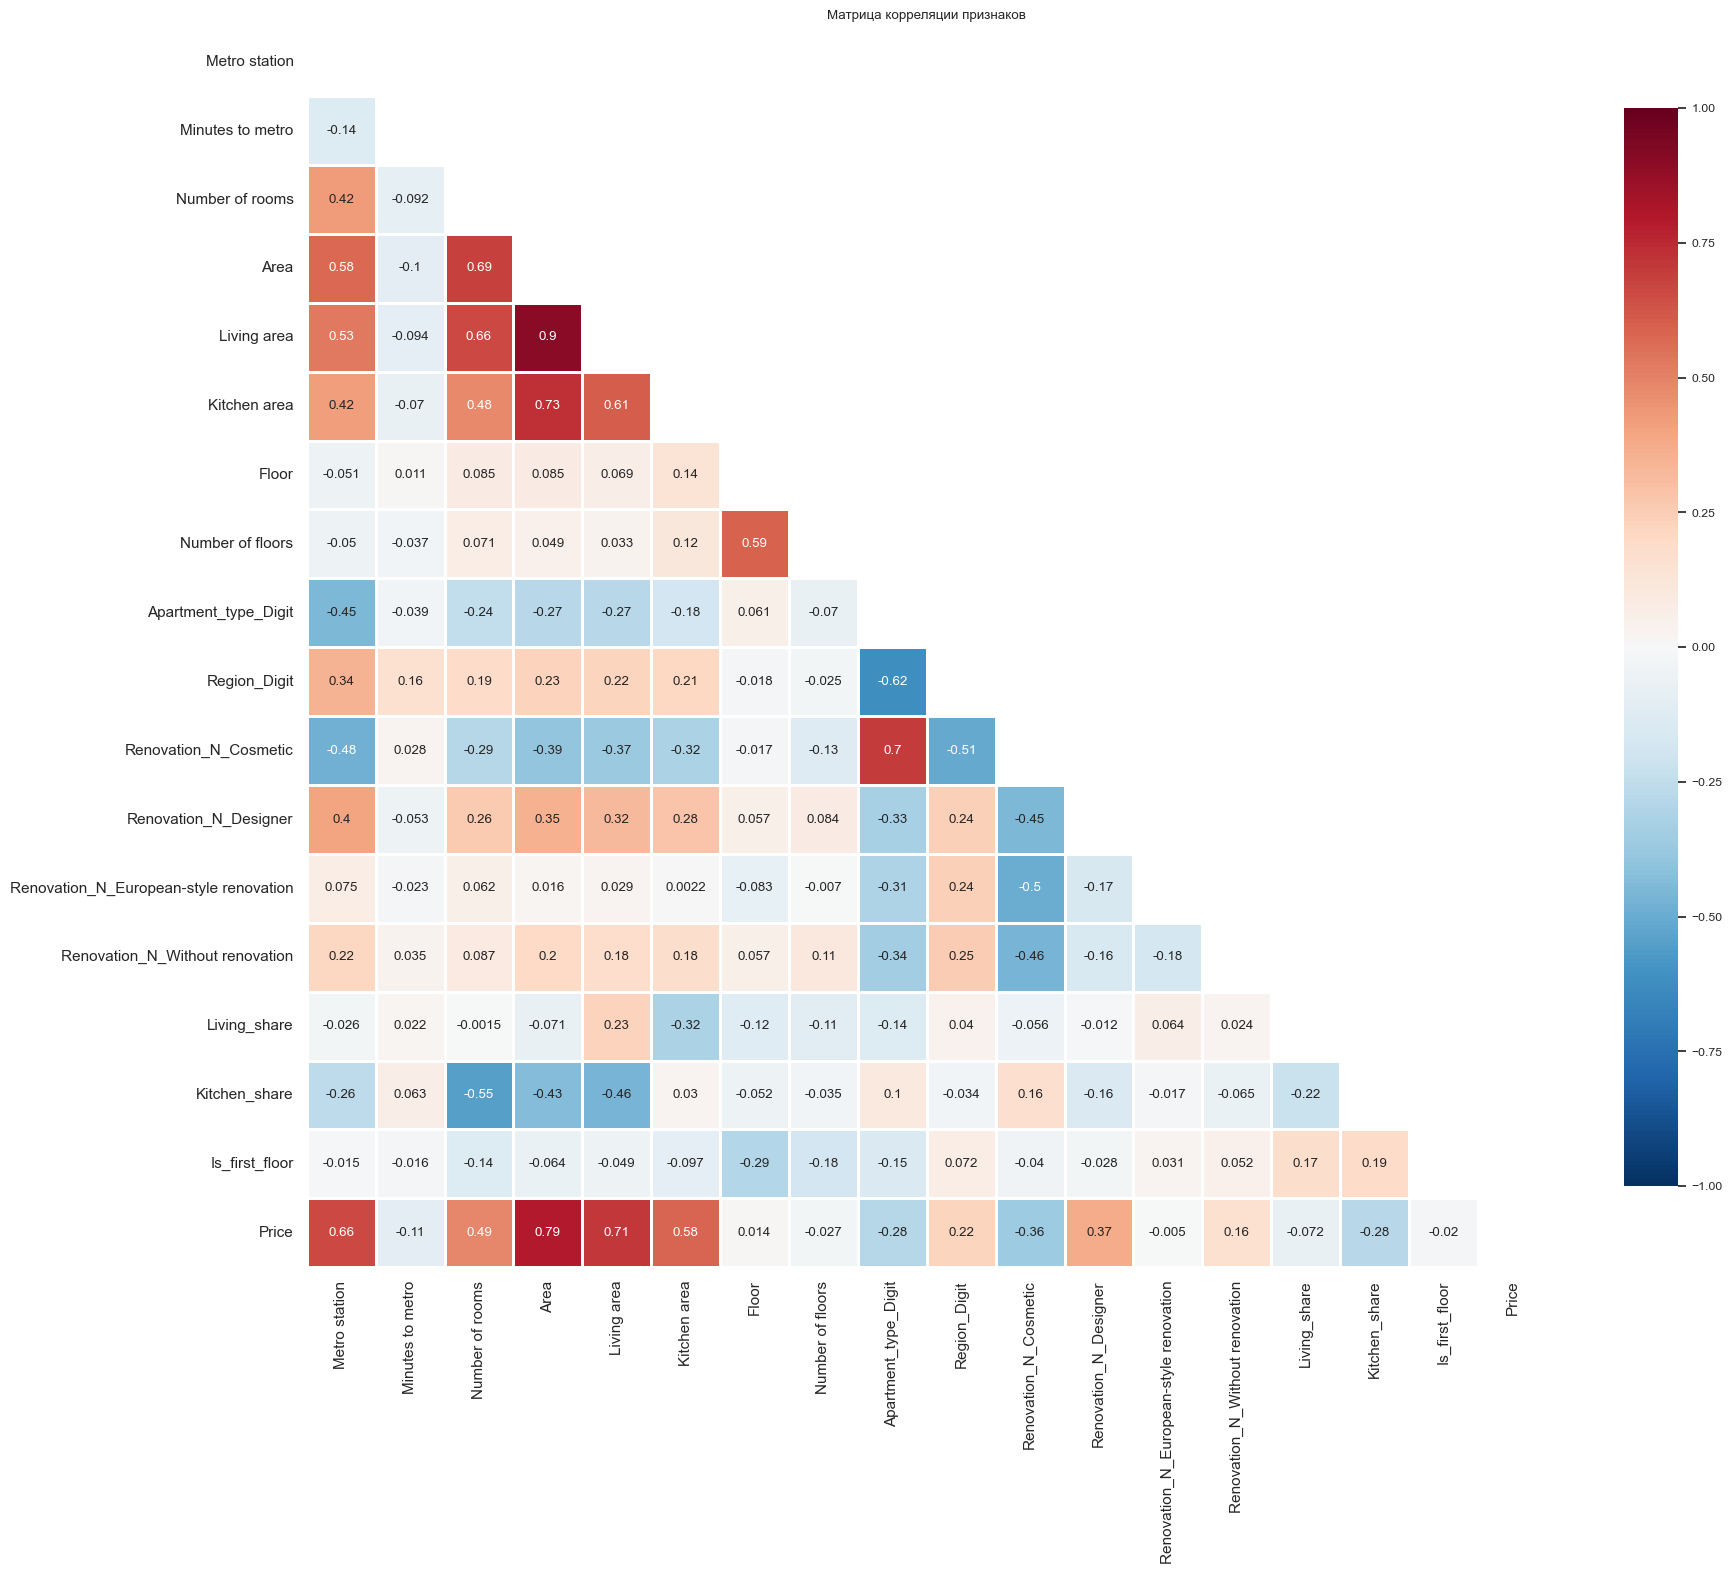

In [154]:
sns.set(style="white")# цвет фона

# построить "маску" для отображения только половины корреляционной матрицы
mask = np.zeros_like(corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=0.8) # размер шрифта

# Построить тепловую карту
sns.heatmap(
    ##################
    data=corr_df,   ### <<<- объект-матрица корреляции
    ##################
    vmin=-1, vmax=1, center=0,
    annot=True,
    cmap = 'RdBu_r',
    mask=mask,   # применить маску
    square=True, # форма ячейки - квадрат
    linewidths=1.0, # зазор между ячейки
    cbar_kws={"shrink": .7}  # уменьшить размер легенды
)
plt.title(u'Матрица корреляции признаков')

Получим столбец для целевого признака.

In [157]:
# Последовательное применение операции:
# - получить единственный столбец,
# - получить абсолютные значения,
# - отсортировать
corr_df[['Price']].abs().sort_values(by="Price")

,Price
Renovation_N_European-style renovation,0.004991
Floor,0.013921
Is_first_floor,0.020467
Number of floors,0.026681
Living_share,0.071601
Minutes to metro,0.108916
Renovation_N_Without renovation,0.157403
Region_Digit,0.220784
Kitchen_share,0.279850
Apartment_type_Digit,0.283504


### Выбор независимых признаков для линейной регрессии

#### 1. Критерии выбора признаков
- Высокая корреляция с целевым признаком (`Price`) → информативные признаки.
- Низкая корреляция между независимыми признаками → избегаем мультиколлинеарности.

---

#### 2. Сильная корреляция с `Price` (|r| > 0.5)
| Признак            | Корреляция с Price |
|--------------------|------------------|
| Area               | 0.795            |
| Living area        | 0.711            |
| Kitchen area       | 0.583            |
| Number of rooms    | 0.491            |

---

#### 3. Мультиколлинеарность
- `Area` и `Living area`: корреляция 0.91 → почти линейно зависимы.
- `Area` и `Kitchen area`: корреляция 0.73 → высокая.
- `Renovation_N_Cosmetic` и `Apartment_type_Digit`: корреляция 0.7 → высокая.

**Вывод:** нельзя включать одновременно сильно коррелирующие признаки.

---

#### 4. Итоговый выбор признаков
**Берём как независимые:**
- `Area` **или** `Living area` (не оба)
- `Number of rooms`
- `Kitchen area` (если не убираем `Area`)
- Категориальные признаки по `Renovation` (например, `Renovation_N_Designer`, `Renovation_N_Cosmetic`, `Renovation_N_Without renovation`) — выбирать наиболее информативные
- Опционально: `Minutes to metro` (корреляция слабая, но может быть полезна)



In [158]:
features1 = ['Area']
features2 = ['Living area', 'Number of rooms', 'Renovation_N_Designer']
features3 = ['Area', 'Number of rooms', 'Renovation_N_Designer',  'Minutes to metro']
# полный список признаков (кроме 'Price')
features = [
    'Renovation_N_European-style renovation',
    'Floor',
    'Is_first_floor',
    'Number of floors',
    'Living_share',
    'Minutes to metro',
    'Renovation_N_Without renovation',
    'Region_Digit',
    'Kitchen_share',
    'Apartment_type_Digit',
    'Renovation_N_Cosmetic',
    'Renovation_N_Designer',
    'Number of rooms',
    'Kitchen area',
    'Metro station',
    'Living area',
    'Area'
]
target   = ['Price']

In [78]:
set(features1+features2+features3)

{'Area',
 'Living area',
 'Minutes to metro',
 'Number of rooms',
 'Renovation_N_Designer'}

# Просмотр характеристик выбранных признаков

<Figure size 700x700 with 0 Axes>

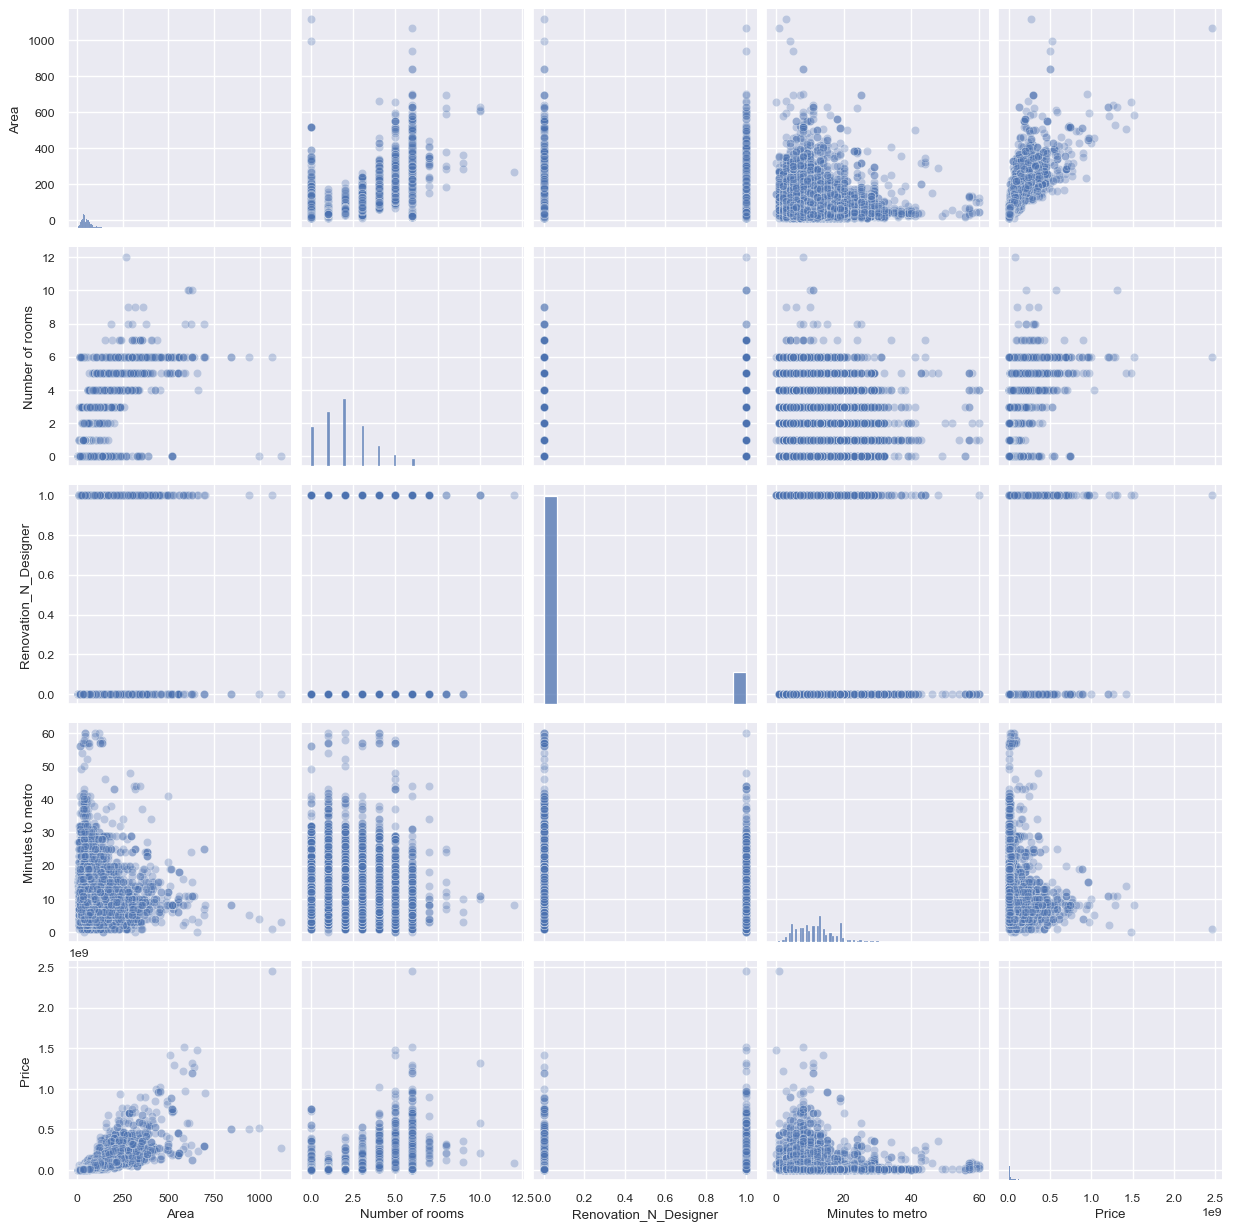

In [161]:
# График признаков попарно
plt.figure(figsize=(7,7))
%config InlineBackend.figure_format = 'png' # формат изображений PNG, для сокращения времени отрисовки графиков

sns.pairplot(
    train_with_target[features3 + target],
    #hue = 'Type',         # Признак разделения
    kind="scatter",        # Тип даграмм: reg,scatter
    diag_kind = 'hist',     # Тип диагоральных даграмм: hist, kde
    plot_kws={'alpha':0.3} # прозрачность точек
)

# Поиск и обработка выбросов

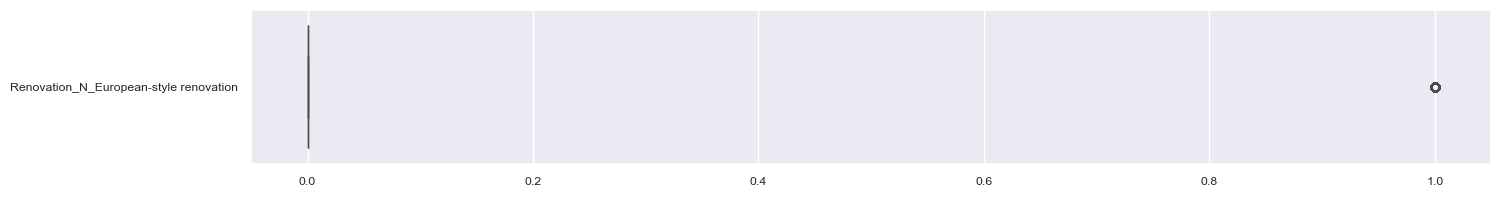

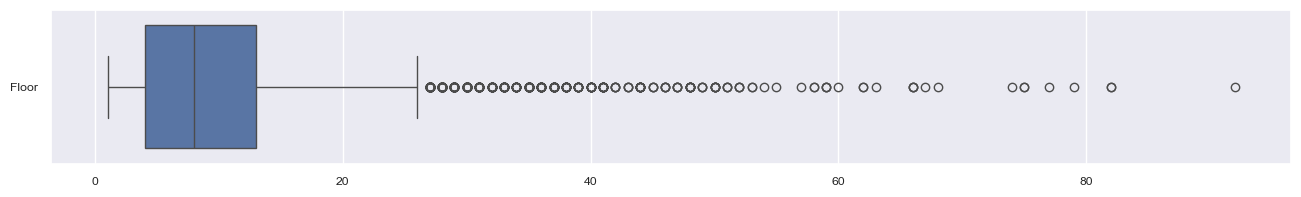

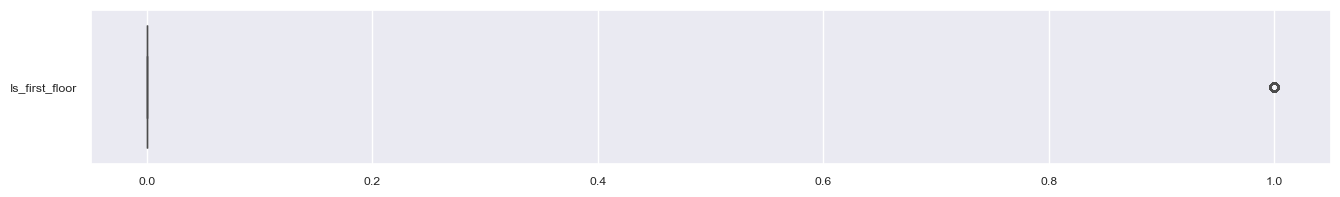

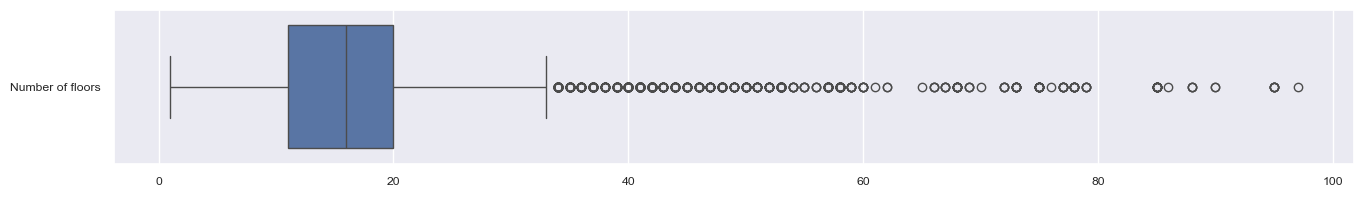

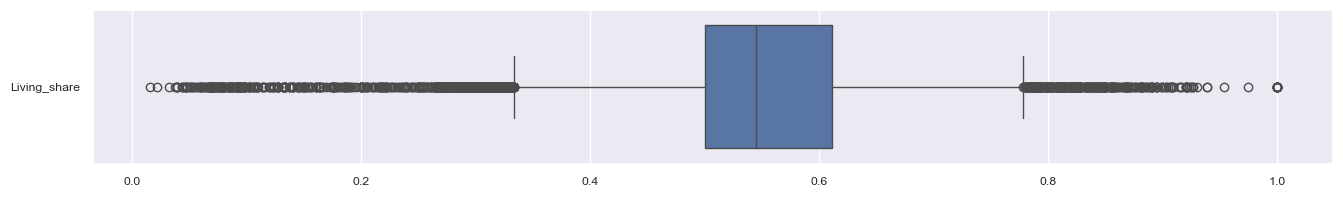

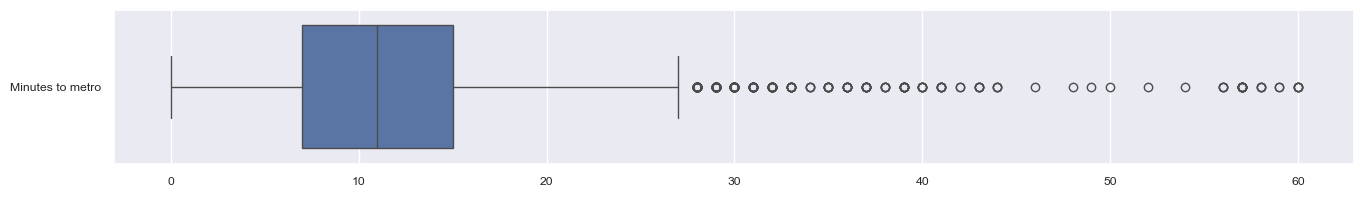

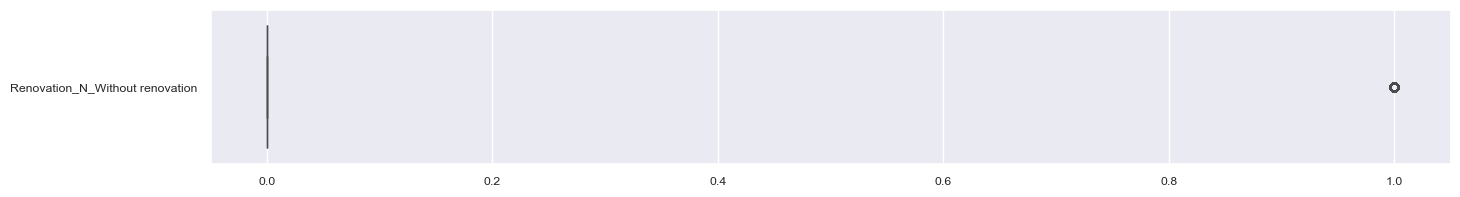

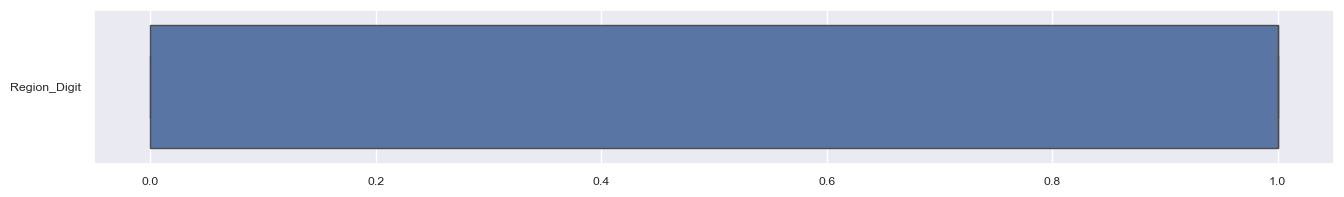

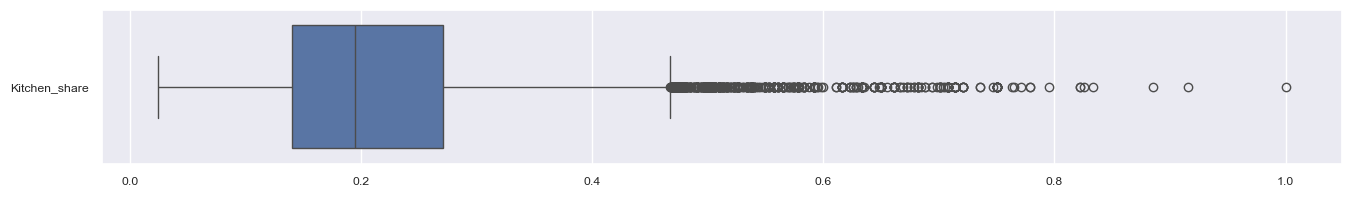

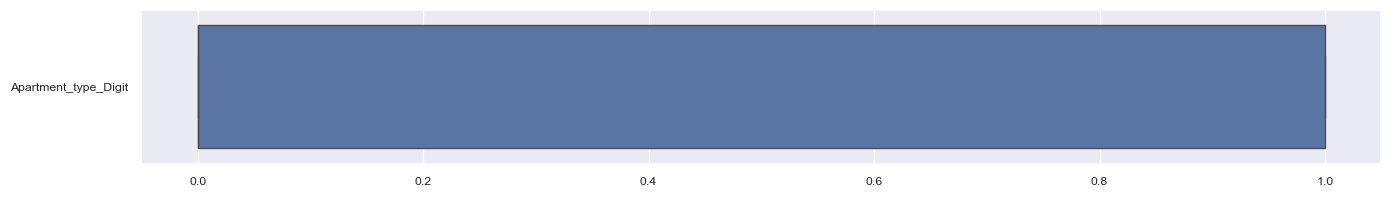

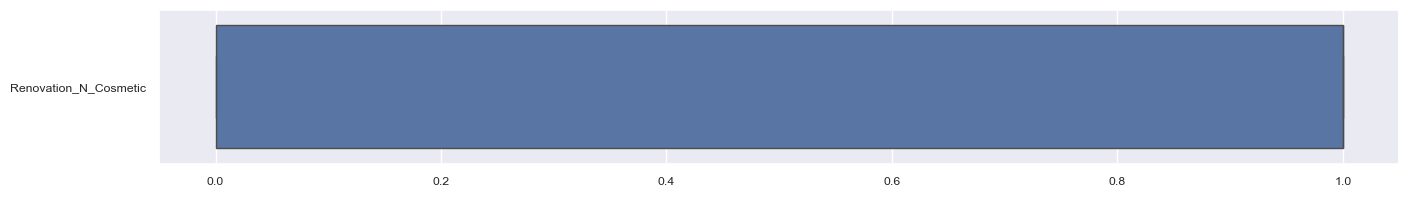

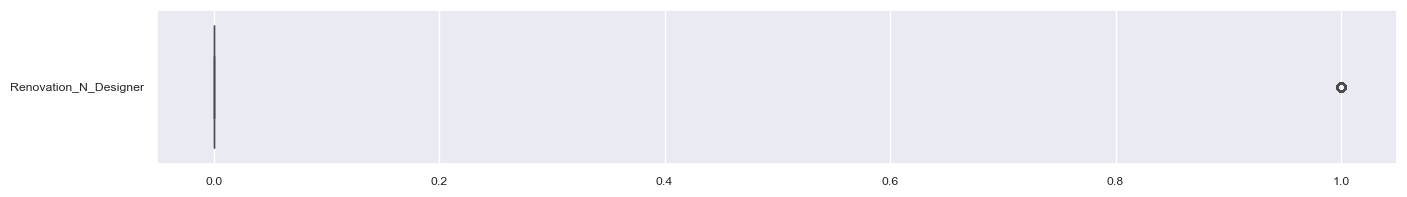

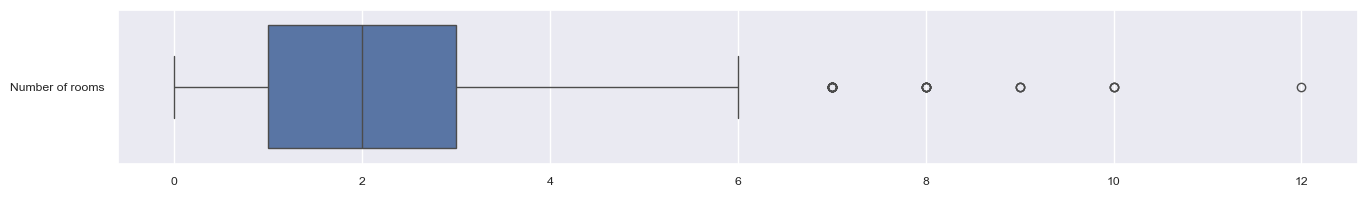

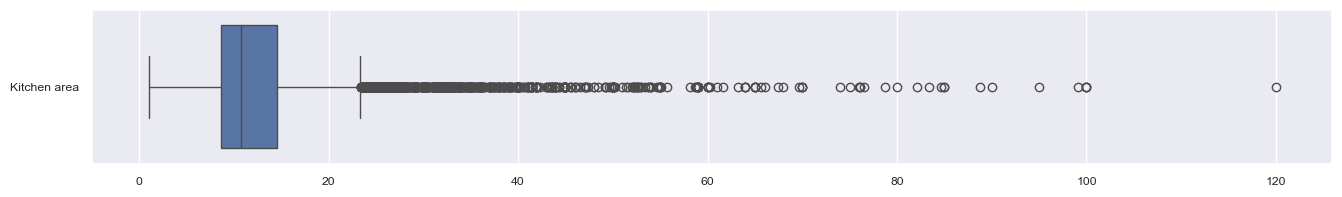

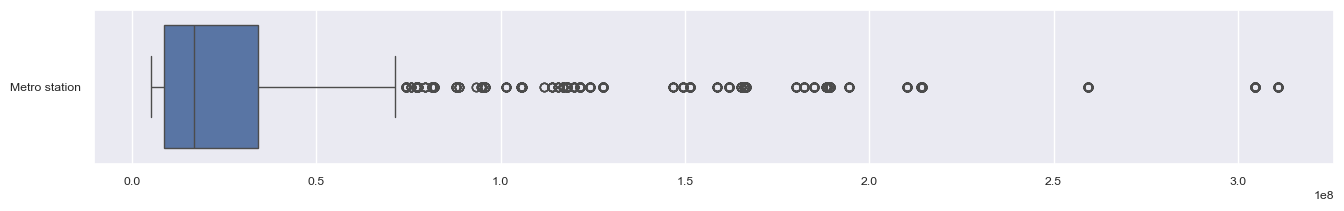

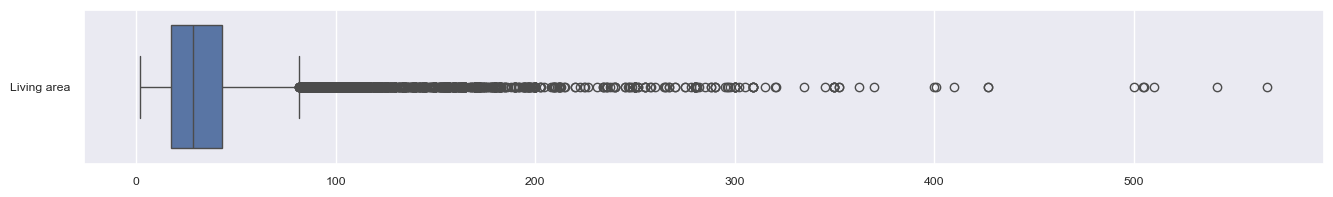

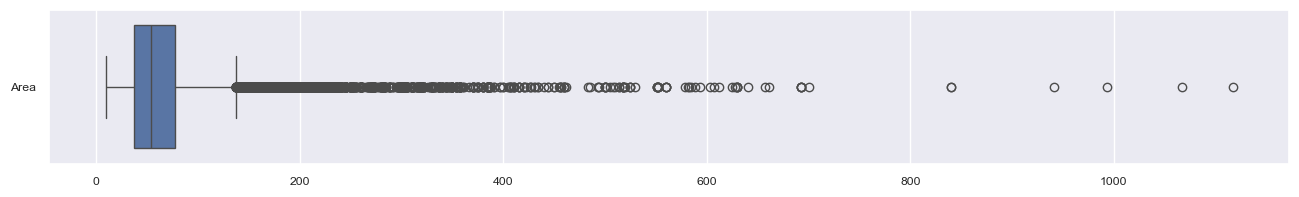

In [167]:
# Цикл: для каждого элемента в объединенном списке
for feature_name in (features):

    # Построить полотно для рисования с указанным размером
    plt.figure(figsize=(16,2))

    # На созданном полотне отрисовать boxplot
    sns.boxplot( data=x_train_enc[[feature_name]], # данные
                    orient='h' # ориентация графика
                    )

Установим границы значений, для тех объектов таблицы, которые должны остаться

Межквартильный размах (IQR)
Это мера разброса данных, которая показывает диапазон центральных 50% значений. Он вычисляется по формуле:

IQR=Q3−Q1

Q1 — это первый квартиль (25-й процентиль), значение, ниже которого находится 25% всех данных.

Q3 — это третий квартиль (75-й процентиль), значение, ниже которого находится 75% всех данных.

Формулы для усов и выбросов
Наиболее распространённый метод построения усов (метод Тьюки) основан на IQR. Он помогает выявить потенциальные выбросы, то есть значения, которые значительно отличаются от основной массы данных.

Формулы для границ:

Нижняя граница уса: Q1−1.5×IQR

Верхняя граница уса: Q3+1.5×IQR

Как это работает:

Нижний ус простирается от Q1 до самого маленького значения в наборе данных, которое больше или равно нижней границе. Если таких значений нет, то ус доходит до минимального значения в наборе.

Верхний ус простирается от Q3 до самого большого значения, которое меньше или равно верхней границе. Если таких значений нет, то ус доходит до максимального значения.

In [166]:
train_with_target.describe()

,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation,Living_share,Kitchen_share,Is_first_floor,Price
count,1.585900e+04,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,15859.000000,1.585900e+04
mean,3.335782e+07,11.901570,2.055741,72.165254,38.526282,12.635790,9.208336,16.602938,0.420960,0.711583,0.566618,0.132606,0.160098,0.140677,0.542200,0.221323,0.068226,3.636947e+07
std,4.761658e+07,6.151241,1.534254,68.730382,38.235096,7.800423,7.540029,9.785339,0.493729,0.453040,0.495558,0.339159,0.366709,0.347699,0.123988,0.111765,0.252142,8.483261e+07
min,5.042299e+06,0.000000,0.000000,9.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,0.024712,0.000000,1.420000e+06
25%,8.778888e+06,7.000000,1.000000,37.430000,17.500000,8.600000,4.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.140135,0.000000,7.041698e+06
50%,1.672917e+07,11.000000,2.000000,53.400000,28.500000,10.700000,8.000000,16.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.545113,0.194805,0.000000,1.136000e+07
75%,3.422628e+07,15.000000,3.000000,77.200000,43.100000,14.500000,13.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.611111,0.270928,0.000000,2.490000e+07
max,3.108477e+08,60.000000,12.000000,1117.000000,566.800000,120.000000,92.000000,97.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.455020e+09


In [165]:
# создадим "словарь"/"хэш-таблицу" для удобного обращения, где ключ - это название признака
cols = features


for col in cols:
        Q1 = train_with_target[col].quantile(0.25)
        Q3 = train_with_target[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 3 * IQR #более мягкие границы: вместо 1.5 * IQR берём 3 * IQR.

        print(f"{col} = ({lower:.2f}, {upper:.2f})")

Renovation_N_European-style renovation = (0.00, 0.00)
Floor = (-9.50, 40.00)
Is_first_floor = (0.00, 0.00)
Number of floors = (-2.50, 47.00)
Living_share = (0.33, 0.94)
Minutes to metro = (-5.00, 39.00)
Renovation_N_Without renovation = (0.00, 0.00)
Region_Digit = (-1.50, 4.00)
Kitchen_share = (-0.06, 0.66)
Apartment_type_Digit = (-1.50, 4.00)
Renovation_N_Cosmetic = (-1.50, 4.00)
Renovation_N_Designer = (0.00, 0.00)
Number of rooms = (-2.00, 9.00)
Kitchen area = (-0.25, 32.20)
Metro station = (-29392194.37, 110568441.39)
Living area = (-20.90, 119.90)
Area = (-22.23, 196.51)


In [168]:
# создадим "словарь"/"хэш-таблицу" для удобного обращения, где ключ - это название признака
tressholdDict = {
    'Price'                     : (0,100_000_000),
    'Area'                      : (0,196.36),
    'Living area'               : (0, 120),
    'Number of rooms'           : (0, 6),
    'Renovation_N_Designer'     : (0, 1),
    'Minutes to metro'          : (0, 39),
    'Renovation_N_European-style renovation' : (0, 1),  # бинарный
    'Is_first_floor'            : (0, 1),               # бинарный
    'Floor'                     : (1, 40),              # отрицательные исключаем
    'Number of floors'          : (1, 47),
    'Living_share'              : (0.3, 0.95),          # доля жилой площади
    'Renovation_N_Without renovation' : (0, 1),
    'Region_Digit'              : (0, 1),
    'Kitchen_share'             : (0, 0.7),             # доля кухни
    'Apartment_type_Digit'      : (0, 4),               # коды типов
    'Renovation_N_Cosmetic'     : (0, 1),
    'Kitchen area'              : (0, 32.2),
    'Metro station'             : (0, 110568441),
}

print (tressholdDict)

{'Price': (0, 100000000), 'Area': (0, 196.36), 'Living area': (0, 120), 'Number of rooms': (0, 6), 'Renovation_N_Designer': (0, 1), 'Minutes to metro': (0, 39), 'Renovation_N_European-style renovation': (0, 1), 'Is_first_floor': (0, 1), 'Floor': (1, 40), 'Number of floors': (1, 47), 'Living_share': (0.3, 0.95), 'Renovation_N_Without renovation': (0, 1), 'Region_Digit': (0, 1), 'Kitchen_share': (0, 0.7), 'Apartment_type_Digit': (0, 4), 'Renovation_N_Cosmetic': (0, 1), 'Kitchen area': (0, 32.2), 'Metro station': (0, 110568441)}


Проверим, какая часть данных выходит за пределы границ значений

In [169]:
# Цикл: для каждого элемента в словаре/хэш-таблице пройтись по ключам - названиям признаков
for feature_name  in tressholdDict:
    threesMin =  tressholdDict[feature_name][0] # извлечь нижнее пороговое
    tresshMax =  tressholdDict[feature_name][1] # извлечь верхнее пороговое

    # Получить кол-во эл. вне пороговых значений. Прием - фильтрация
    over_count = len(  train_with_target[
                            ~((train_with_target[feature_name] >= threesMin ) & (train_with_target[feature_name] <= tresshMax)) # фильтр по двум границам. ~ инверсия логических значений
                            ]
                    )

    dcount = train_with_target[feature_name].count() # кол-во эл. общее

    print ('''{}. Принимаем пороговые значение равными {}.
        Кол-во эл. вне пороговых - {} из {} значение(ий) ({:.1%})\n'''.format(
        feature_name,
        tressholdDict[feature_name],
        over_count,
        dcount,
        over_count/ dcount,
    ))

Price. Принимаем пороговые значение равными (0, 100000000).
        Кол-во эл. вне пороговых - 1295 из 15859 значение(ий) (8.2%)

Area. Принимаем пороговые значение равными (0, 196.36).
        Кол-во эл. вне пороговых - 821 из 15859 значение(ий) (5.2%)

Living area. Принимаем пороговые значение равными (0, 120).
        Кол-во эл. вне пороговых - 611 из 15859 значение(ий) (3.9%)

Number of rooms. Принимаем пороговые значение равными (0, 6).
        Кол-во эл. вне пороговых - 33 из 15859 значение(ий) (0.2%)

Renovation_N_Designer. Принимаем пороговые значение равными (0, 1).
        Кол-во эл. вне пороговых - 0 из 15859 значение(ий) (0.0%)

Minutes to metro. Принимаем пороговые значение равными (0, 39).
        Кол-во эл. вне пороговых - 47 из 15859 значение(ий) (0.3%)

Renovation_N_European-style renovation. Принимаем пороговые значение равными (0, 1).
        Кол-во эл. вне пороговых - 0 из 15859 значение(ий) (0.0%)

Is_first_floor. Принимаем пороговые значение равными (0, 1).
      

In [175]:
def filter_outliers(df, tressholdDict, exclude_cols=None):
    """
    Фильтрует DataFrame по заданным границам из словаря tressholdDict.
    exclude_cols — список столбцов, которые не участвуют в фильтрации,
    но сохраняются в итоговой таблице.
    """
    if exclude_cols is None:
        exclude_cols = []

    df_filtered = df.copy()
    initial_len = len(df_filtered)

    for feature_name, (th_min, th_max) in tressholdDict.items():
        if feature_name in df_filtered.columns and feature_name not in exclude_cols:
            df_filtered = df_filtered[
                (df_filtered[feature_name] >= th_min) & 
                (df_filtered[feature_name] <= th_max)
            ]
            print(f"Обработан {feature_name}")

    print(f"Отброшено {initial_len - len(df_filtered)} строк. Осталось {len(df_filtered)} строк.")
    return df_filtered

In [176]:
# train_with_target
train_with_target_filtered = filter_outliers(train_with_target, tressholdDict)

# test с целевой переменной
test_with_target = pd.concat([x_test_enc, y_test], axis=1)

# фильтрация train
train_with_target_filtered = filter_outliers(train_with_target, tressholdDict)

# фильтрация test
test_with_target_filtered = filter_outliers(test_with_target, tressholdDict)

# если нужно отдельно только X без целевой:
x_train_enc_filtered = train_with_target_filtered.drop(columns=['Price'])
y_train_filtered = train_with_target_filtered['Price']

x_test_enc_filtered = test_with_target_filtered.drop(columns=['Price'])
y_test_filtered = test_with_target_filtered['Price']

# Очистка исходного df
df_filtered = filter_outliers(df, tressholdDict, exclude_cols=['Metro station'])

Обработан Price
Обработан Area
Обработан Living area
Обработан Number of rooms
Обработан Renovation_N_Designer
Обработан Minutes to metro
Обработан Renovation_N_European-style renovation
Обработан Is_first_floor
Обработан Floor
Обработан Number of floors
Обработан Living_share
Обработан Renovation_N_Without renovation
Обработан Region_Digit
Обработан Kitchen_share
Обработан Apartment_type_Digit
Обработан Renovation_N_Cosmetic
Обработан Kitchen area
Обработан Metro station
Отброшено 2625 строк. Осталось 13234 строк.
Обработан Price
Обработан Area
Обработан Living area
Обработан Number of rooms
Обработан Renovation_N_Designer
Обработан Minutes to metro
Обработан Renovation_N_European-style renovation
Обработан Is_first_floor
Обработан Floor
Обработан Number of floors
Обработан Living_share
Обработан Renovation_N_Without renovation
Обработан Region_Digit
Обработан Kitchen_share
Обработан Apartment_type_Digit
Обработан Renovation_N_Cosmetic
Обработан Kitchen area
Обработан Metro station
От

Renovation_N_European-style renovation 0 1
Floor 1.0 40.0
Is_first_floor 0 1
Number of floors 1 47
Living_share 0.3 0.9389671361502347
Minutes to metro 0.0 39.0
Renovation_N_Without renovation 0 1
Region_Digit 0 1
Kitchen_share 0.03682008368200837 0.697986577181208
Apartment_type_Digit 0 1
Renovation_N_Cosmetic 0 1
Renovation_N_Designer 0 1
Number of rooms 0.0 6.0
Kitchen area 1.0 32.0
Metro station 5042298.694248978 105482932.31961194
Living area 4.0 120.0
Area 9.0 195.0
Price 1420000.0 100000000.0


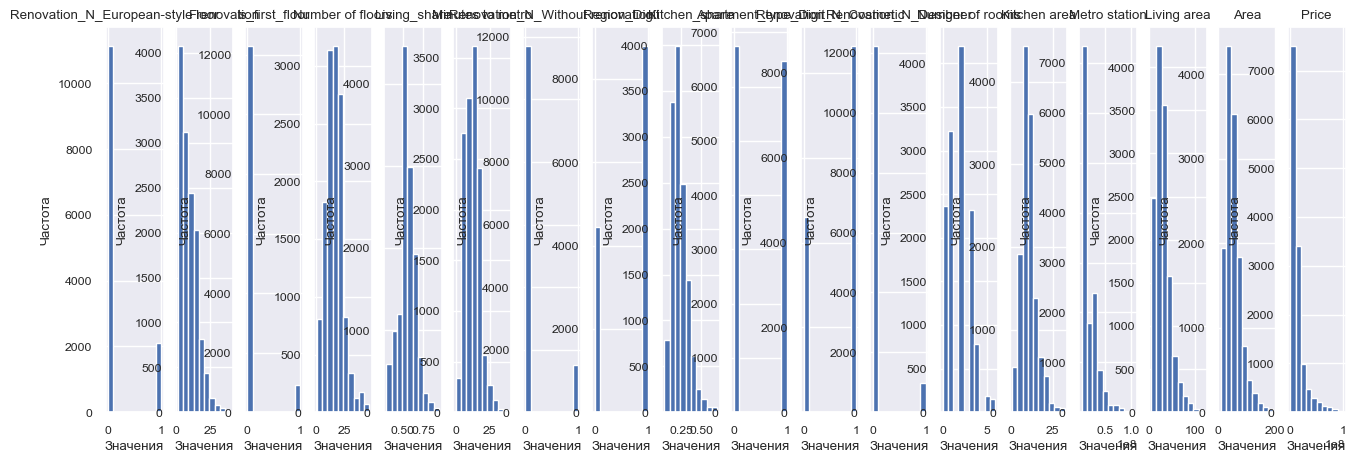

In [177]:
# Строим гистограммы по каждому признаку:
# data[features].hist() #Упрощенный вывод графиков

plt.figure(figsize=(16, 5))
plot_number = 0

for feature_name in (features+target):
    plot_number += 1

    plt.subplot(1, len(features+target), plot_number)

    plt.hist(train_with_target_filtered[feature_name]) # Построение гистрограммы

    plt.title(feature_name)
    plt.xlabel(u'Значения')
    plt.ylabel(u'Частота')
    print (feature_name,
            train_with_target_filtered[feature_name].min(),
            train_with_target_filtered[feature_name].max())

## Сохранение данных

In [178]:
df_filtered.to_csv(
    '../Data/Moscow_Housing_Price_FILTERED.csv',  # путь и имя файла
    index=False,                                  # не сохраняем индексы
    encoding='utf-8'                              # кодировка
)

# Построение модели 1

In [193]:
model_Area = linear_model.LinearRegression()

In [194]:
y_train_filtered

20126     4130000.0
3955     60636576.0
21155    12040000.0
8524     33438000.0
8792     27000000.0
            ...    
11985     4899000.0
5496     10800000.0
7012     11000000.0
18436    17012998.0
4561     13550000.0
Name: Price, Length: 13234, dtype: float64

In [195]:
# Вычислить коэфф. Ki в функции y(x)=Ki*xi + .... + B
# на тренировочном наборе, т.е. обучить модель
model_Area.fit(
    x_train_enc_filtered[['Area']],
    y_train_filtered
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [196]:
# Получить вычисленные(predicted) зн. на проверочном наборе
# y_pred = fittedModel.predict(x_test)
y_predicted_on_Area = model_Area.predict(x_test_enc_filtered[['Area']])

## Функции для построения графиков

In [206]:
def PLOTSCATTER(x_train, y_train, x_test, y_test, y_pred, model, target_name="Price") -> None:
    '''
    Функция построения графиков
    :param x_train: тренировочные признаки (один столбец)
    :param y_train: тренировочные значения целевой переменной
    :param x_test: проверочные признаки (один столбец)
    :param y_test: проверочные значения целевой переменной
    :param y_pred: предсказанные значения целевой переменной
    :param model: обученная модель (LinearRegression)
    :param target_name: название целевой переменной для подписи оси
    '''
    plt.figure(figsize=(15,5))

    # Точечные диаграммы
    plt.scatter(x_train, y_train, alpha=0.3, label='Тренировочный')
    plt.scatter(x_test,  y_test,  alpha=0.3, label='Проверочный')

    # Коэффициенты модели
    coef = np.ravel(model.coef_)[0]   # превращаем в число
    intercept = model.intercept_ if np.isscalar(model.intercept_) else model.intercept_[0]

    # Линия предсказаний
    plt.scatter(
        x_test, y_pred,
        lw=2, color='red',
        label=f"y_pred = {coef:.3f} * x + {intercept:.3f}"
    )

    plt.grid(True)
    plt.legend(loc="best")
    plt.xlabel(x_train.columns[0])   # подпись по признаку
    plt.ylabel(target_name)          # подпись по целевой
    plt.title('График разброса')
    plt.show()

def PLOTHIST(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(6,4))

    # Гистограмма и Плотность распределения - sns.distplot
    # data = y_true - y_pred
    sns.histplot( data = y_test - y_pred,
                color="red",
                kde=True, # оценка плотности в виде кривой
                stat="density",# density: общая площадь равна 1
                )

    # Осевая линия
    # plt.plot(
    #     [0, 0],
    #     [0, 10 * pow(10,-7)], '--', lw=2, c='r')

    plt.ylabel(u'Плотность')
    plt.xlabel(u'Значение ошибки')
    plt.title(u'Плотность распределения и гистограмма ошибок');
    plt.show()

def PLOT34(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(12,6))

    # == Диаграмма рассеяния вычисленных значений ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1, color = "#17becf")
    plt.plot(  [ np.min(y_test), np.max(y_test) ], # x1,x2
               [ np.min(y_test), np.max(y_test) ], # y1,y2
               '--',
               alpha=0.7, lw=3, color = "black")
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7

    # == Диаграмма рассеяния ошибок ==
    # создать второе полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7
#--------------------------------------------------------------------------

def PRINTR2(model, y_test, y_pred) -> None:
    '''
    Вывод формулы линейной регрессии и метрик качества
    '''
    print("Линейная регрессия.")
    print("Формула линейной регрессии y(X) = k0*x0 + ... + kN*xN + b")
    print("y = f(X) = ")

    # Приводим коэффициенты к одномерному массиву
    coefs = np.ravel(model.coef_)
    intercept = model.intercept_

    for i, kN in enumerate(coefs):
        print(f"{' ' if i==0 else '+'} {kN:.3f} * x{i}")
    print(f"+ {intercept:.3f}\n")

    # Метрики
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = metrics.r2_score(y_test, y_pred)

    print("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format(mae))
    print("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format(mse))
    print("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format(rmse))
    print("R2  : {:>9,.3f} (коэфф. детерминации)".format(r2))

### Графики для модели 1

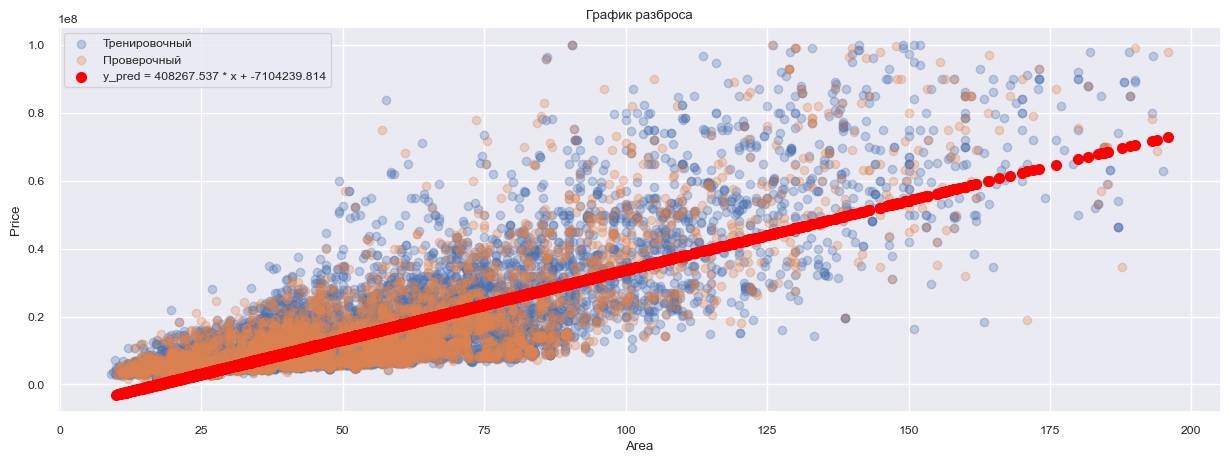

In [200]:
PLOTSCATTER(
    x_train = x_train_enc_filtered[['Area']],
    y_train = y_train_filtered,
    x_test = x_test_enc_filtered[['Area']],
    y_test = y_test_filtered,
    y_pred = y_predicted_on_Area,
    model = model_Area
)

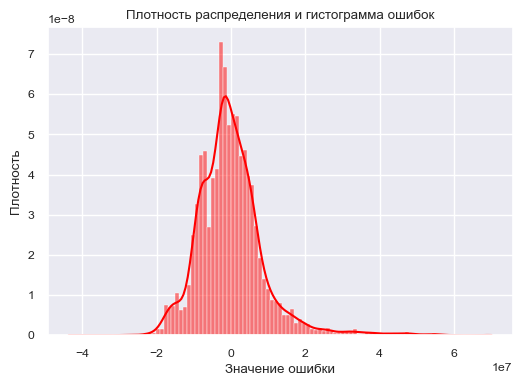

In [202]:
PLOTHIST(
    y_test = y_test_filtered,
    y_pred = y_predicted_on_Area
)

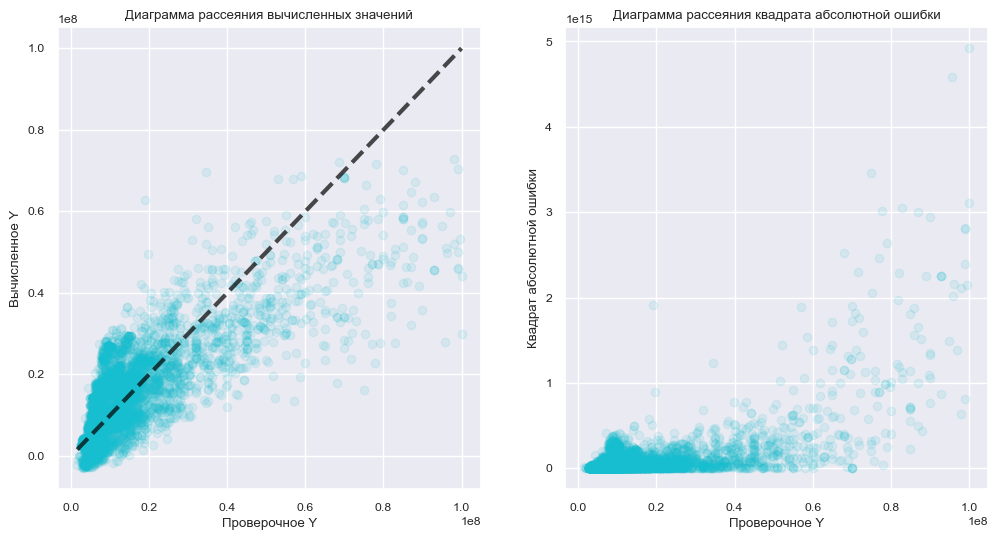

In [203]:
PLOT34(
    y_test = y_test_filtered,
    y_pred = y_predicted_on_Area
)

In [207]:
PRINTR2(
    model = model_Area,
    y_test = y_test_filtered,
    y_pred = y_predicted_on_Area
)

Линейная регрессия.
Формула линейной регрессии y(X) = k0*x0 + ... + kN*xN + b
y = f(X) = 
  408267.537 * x0
+ -7104239.814

MAE : 6,381,172.001 (средняя абсолютная ошибка)
MSE : 82,959,152,743,949.156250 (среднеквадратичная ошибка)
RMSE: 9,108,191.518844 (кв. корень из среднеквадратичной ошибки)
R2  :     0.597 (коэфф. детерминации)


### Многомерная модель от 2 набора переменных

In [208]:
features2

['Living area', 'Number of rooms', 'Renovation_N_Designer']

In [209]:
model_LA_NR_RnD = linear_model.LinearRegression()

In [210]:
model_LA_NR_RnD.fit(
    x_train_enc_filtered[features2],
    y_train_filtered
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [211]:
# Получить вычисленные(predicted) зн. на проверочном наборе
# y_pred = fittedModel.predict(x_test)
y_predicted_on_LA_NR_RnD = model_LA_NR_RnD.predict(x_test_enc_filtered[features2])

### Графики для 2 модели

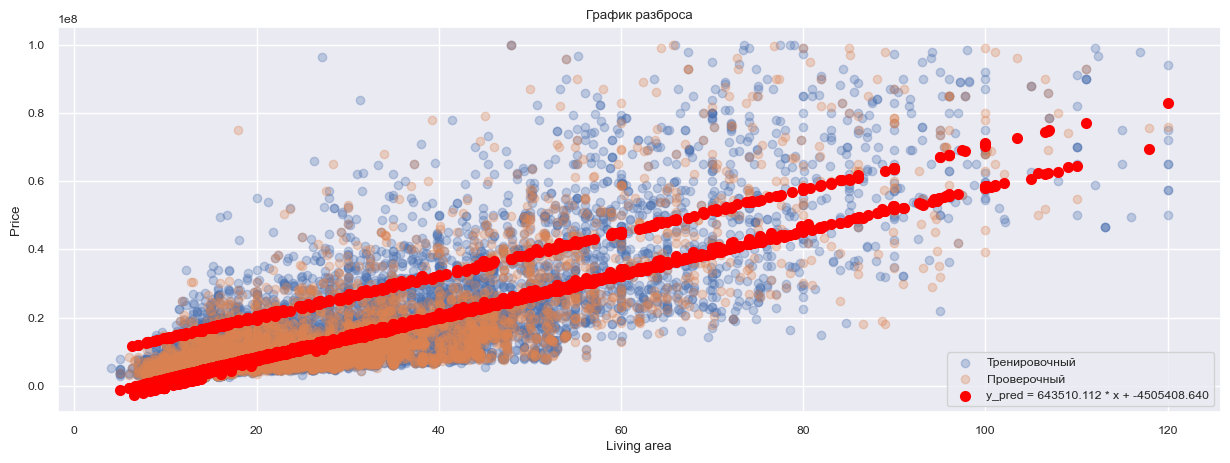

In [212]:
PLOTSCATTER(
    x_train = x_train_enc_filtered[['Living area']],
    y_train = y_train_filtered,
    x_test  = x_test_enc_filtered[['Living area']],
    y_test  = y_test_filtered,
    y_pred  = y_predicted_on_LA_NR_RnD,
    model   = model_LA_NR_RnD
)

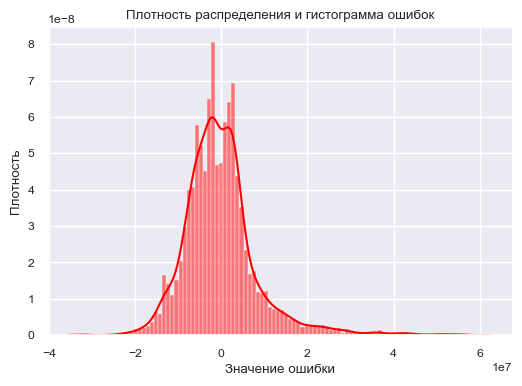

In [213]:
PLOTHIST(
    y_test = y_test_filtered,
    y_pred = y_predicted_on_LA_NR_RnD
)

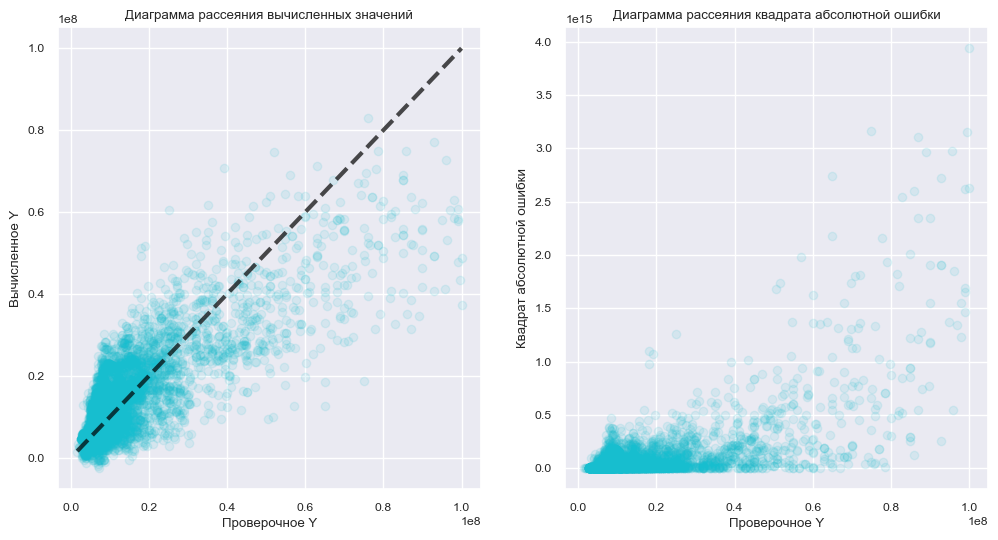

In [214]:
PLOT34(
    y_test = y_test_filtered,
    y_pred = y_predicted_on_LA_NR_RnD
)

In [215]:
PRINTR2(
    model = model_LA_NR_RnD,
    y_test = y_test_filtered,
    y_pred = y_predicted_on_LA_NR_RnD
)

Линейная регрессия.
Формула линейной регрессии y(X) = k0*x0 + ... + kN*xN + b
y = f(X) = 
  643510.112 * x0
+ -384021.069 * x1
+ 12070750.351 * x2
+ -4505408.640

MAE : 6,128,550.918 (средняя абсолютная ошибка)
MSE : 78,188,935,514,284.593750 (среднеквадратичная ошибка)
RMSE: 8,842,450.764029 (кв. корень из среднеквадратичной ошибки)
R2  :     0.620 (коэфф. детерминации)


### Многомерная модель от 3 набора переменных

In [216]:
features3

['Area', 'Number of rooms', 'Renovation_N_Designer', 'Minutes to metro']

In [218]:
model_A_NR_RnD_MtM = linear_model.LinearRegression()

In [219]:
model_A_NR_RnD_MtM.fit(
    x_train_enc_filtered[features3],
    y_train_filtered
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [220]:
# Получить вычисленные(predicted) зн. на проверочном наборе
# y_pred = fittedModel.predict(x_test)
y_predicted_on_A_NR_RnD_MtM = model_A_NR_RnD_MtM.predict(x_test_enc_filtered[features3])

### Графики для 3 модели

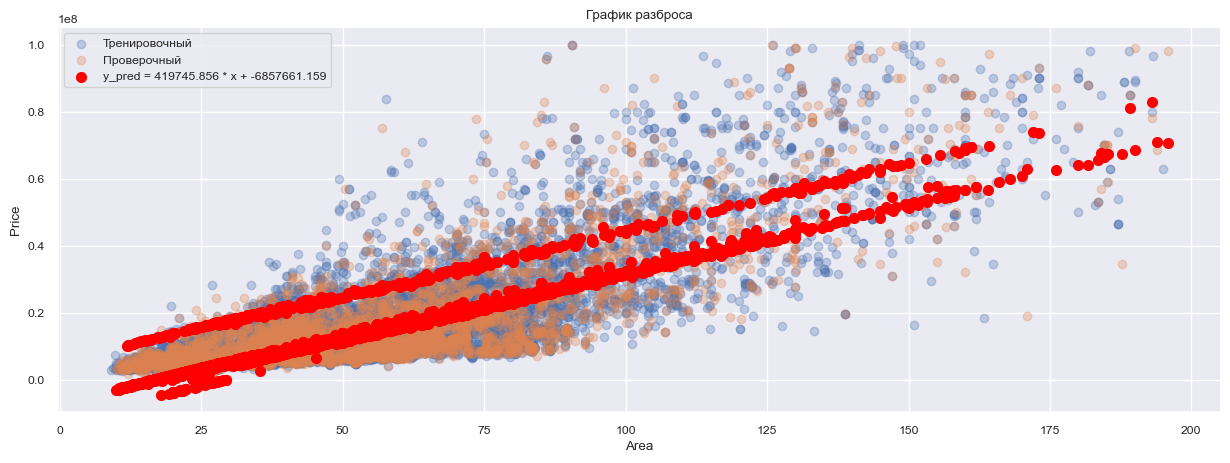

In [221]:
PLOTSCATTER(
    x_train = x_train_enc_filtered[['Area']],
    y_train = y_train_filtered,
    x_test  = x_test_enc_filtered[['Area']],
    y_test  = y_test_filtered,
    y_pred  = y_predicted_on_A_NR_RnD_MtM,
    model   = model_A_NR_RnD_MtM
)

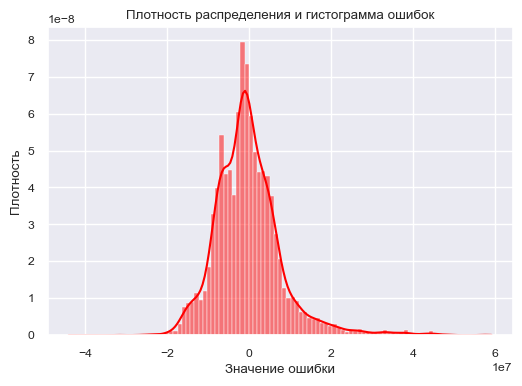

In [222]:
PLOTHIST(
    y_test = y_test_filtered,
    y_pred = y_predicted_on_A_NR_RnD_MtM
)

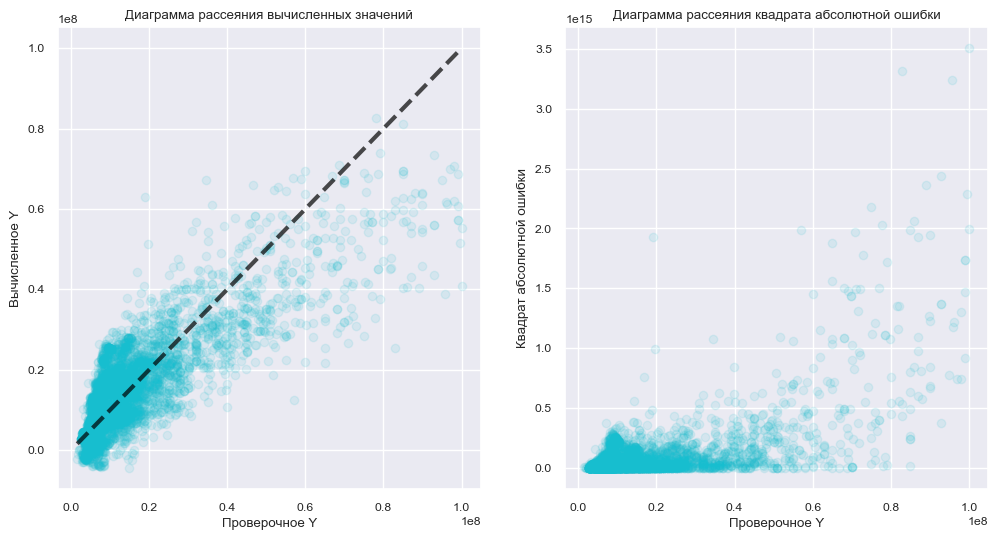

In [223]:
PLOT34(
    y_test = y_test_filtered,
    y_pred = y_predicted_on_A_NR_RnD_MtM
)

In [224]:
PRINTR2(
    model = model_A_NR_RnD_MtM,
    y_test = y_test_filtered,
    y_pred = y_predicted_on_A_NR_RnD_MtM
)

Линейная регрессия.
Формула линейной регрессии y(X) = k0*x0 + ... + kN*xN + b
y = f(X) = 
  419745.856 * x0
+ -861022.144 * x1
+ 12360970.603 * x2
+ -21101.388 * x3
+ -6857661.159

MAE : 5,904,105.739 (средняя абсолютная ошибка)
MSE : 70,202,061,114,380.335938 (среднеквадратичная ошибка)
RMSE: 8,378,667.024914 (кв. корень из среднеквадратичной ошибки)
R2  :     0.659 (коэфф. детерминации)


# Итоги. Сравнение полученных моделей

Исходный размер:
(22676, 12)
Итого: 22676 записи, 12 столбец (признак).

In [226]:
print("Размер исходного DataFrame", df.shape)
print ("Отброшено {} строк. Осталось после фильтрации {} строк.".format(
    len(df)  - len(df_filtered),
    len(df_filtered))
)

Размер исходного DataFrame (22656, 18)
Отброшено 3290 строк. Осталось после фильтрации 19366 строк.


In [227]:
print("\nПервая модель\n")
PRINTR2(
    model = model_Area,
    y_test = y_test_filtered,
    y_pred = y_predicted_on_Area
)
print("\nВторая модель\n")
PRINTR2(
    model = model_LA_NR_RnD,
    y_test = y_test_filtered,
    y_pred = y_predicted_on_LA_NR_RnD
)
print("\nТретья модель\n")
PRINTR2(
    model = model_A_NR_RnD_MtM,
    y_test = y_test_filtered,
    y_pred = y_predicted_on_A_NR_RnD_MtM
)


Первая модель

Линейная регрессия.
Формула линейной регрессии y(X) = k0*x0 + ... + kN*xN + b
y = f(X) = 
  408267.537 * x0
+ -7104239.814

MAE : 6,381,172.001 (средняя абсолютная ошибка)
MSE : 82,959,152,743,949.156250 (среднеквадратичная ошибка)
RMSE: 9,108,191.518844 (кв. корень из среднеквадратичной ошибки)
R2  :     0.597 (коэфф. детерминации)

Вторая модель

Линейная регрессия.
Формула линейной регрессии y(X) = k0*x0 + ... + kN*xN + b
y = f(X) = 
  643510.112 * x0
+ -384021.069 * x1
+ 12070750.351 * x2
+ -4505408.640

MAE : 6,128,550.918 (средняя абсолютная ошибка)
MSE : 78,188,935,514,284.593750 (среднеквадратичная ошибка)
RMSE: 8,842,450.764029 (кв. корень из среднеквадратичной ошибки)
R2  :     0.620 (коэфф. детерминации)

Третья модель

Линейная регрессия.
Формула линейной регрессии y(X) = k0*x0 + ... + kN*xN + b
y = f(X) = 
  419745.856 * x0
+ -861022.144 * x1
+ 12360970.603 * x2
+ -21101.388 * x3
+ -6857661.159

MAE : 5,904,105.739 (средняя абсолютная ошибка)
MSE : 70,202,0

Оцените в минутах время затраченное на выполнение основных этапов текущей работы, согласно методологии CRISP, затем заполните эту информацию в следующей ячейке для получения столбчатой диаграммы.

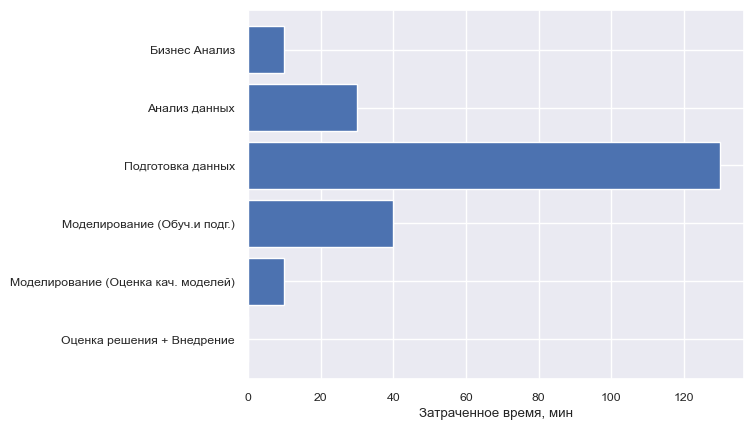

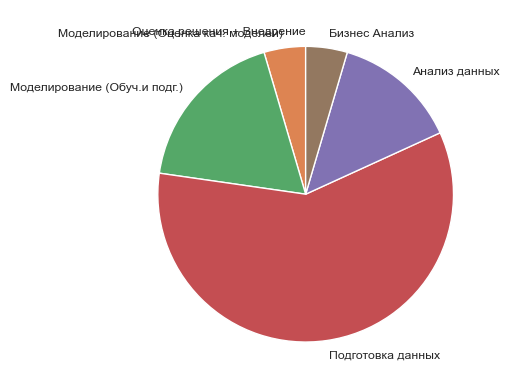

In [76]:
# Создадим датафрейм для хранения значений
dfSpendTimeLab1 = pd.DataFrame.from_dict(
{
    "1": {"step": "Бизнес Анализ",                       "duration, min" : 10  },  # понимание задачи
    "2": {"step": "Анализ данных",                       "duration, min" : 30  },  # загрузка + первичный осмотр
    "3": {"step": "Подготовка данных",                   "duration, min" : 130 },  # фильтрация (40) + кодирование (60) + мелкие доработки (30)
    "4": {"step": "Моделирование (Обуч.и подг.)",        "duration, min" : 40  },  # обучение моделей и графики
    "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" : 10  },  # метрики, сравнение
    "6": {"step": "Оценка решения + Внедрение",          "duration, min" : 0  },  # выводы и оформление
}
, orient="index"
).sort_index(ascending=False)

# Построить столбчатую диаграмму
fig = plt.figure()
plt.barh(y = dfSpendTimeLab1["step"], width= dfSpendTimeLab1["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Построить круговую диаграмму
fig = plt.figure()
plt.pie(x= dfSpendTimeLab1["duration, min"], labels=dfSpendTimeLab1["step"],  startangle = 90 )

plt.show()

# Выводы по работе

Сравните модели между собой по метрике точности R2:
- какая из полученных моделей имеет макс. значение метрики R2?
- во сколько раз метрики R2 отличаются между моделями?
- какие из выбранных признаков X являются необходимыми для увеличения R2?
- как изменяется метрика R2 при дополнении одних признаков X другими?

### 1. Сравнение моделей по метрике R²
| Модель | Признаки X | R² |
|--------|------------|----|
| Модель 1 | ['Area'] | 0.613 |
| Модель 2 | ['Living area', 'Number of rooms', 'Renovation_N_Designer'] | 0.576 |
| Модель 3 | ['Area', 'Number of rooms', 'Renovation_N_Designer', 'Minutes to metro'] | 0.668 |

- **Максимальное значение R²** = 0.668 у **Модели 3** → эта модель объясняет наибольшую долю дисперсии цены.
- **Сравнение R² между моделями**:  
  - Модель 3 / Модель 1 ≈ 1.09 → улучшение R² на ~9%  
  - Модель 3 / Модель 2 ≈ 1.16 → улучшение R² на ~16%  

---

### 2. Влияние признаков на R²
- **Area** является сильным и необходимым признаком:  
  - Модель 1 с одним признаком `Area` имеет R² = 0.613.  
  - Добавление других признаков к Area (Модель 3) увеличивает R² до 0.668.  

- **Living area, Number of rooms, Renovation_N_Designer** (Модель 2) без Area дают R² = 0.576 → меньше, чем модель с одним Area.  
  - Значит, Area содержит ключевую информацию о цене.

- **Minutes to metro** добавлен в Модель 3, но влияние на R² незначительное (0.668 vs 0.613 с Area + другие признаки).  

---

### 3. Как изменяется R² при дополнении признаков
- Модель 1 → 1 признак → R² = 0.613  
- Модель 2 → 3 признака без Area → R² = 0.576 (ниже, чем у одного сильного признака)  
- Модель 3 → комбинация признаков с Area → R² = 0.668 (лучший результат)  

**Вывод:**  
- Для увеличения точности модели (R²) **ключевым является Area**.  
- Дополнение другими признаками (Number of rooms, Renovation_N_Designer, Minutes to metro) немного улучшает R², но их влияние вторично.  
- Удаление Area резко снижает качество модели, даже если добавить несколько других признаков.  


